In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('cleaned_data.csv')

In [4]:
df.describe()

,Open,High,Low,Close
count,7098.000000,7098.000000,7098.000000,7098.000000
mean,110.649592,111.101390,110.155538,110.644679
std,14.894489,14.980412,14.806835,14.894081
min,75.750000,75.973999,75.570000,75.739998
25%,104.180000,104.614250,103.712250,104.176752
50%,110.698498,111.100502,110.308498,110.708500
75%,119.260752,119.782247,118.720001,119.262251
max,151.645996,151.936996,151.240005,151.645996


In [6]:
df.set_index('Date', inplace=True)

# split train，validation, test set

In [7]:
#split the train, validation and test set
l = len(df)
split_point = int(0.6*l)
split_point2 = int(0.8*l)
train = df[:split_point]
validation = df[split_point: split_point2]
test = df[split_point2:]

In [8]:
len(train), len(validation), len(test)

(4258, 1420, 1420)

# The target: 3-days forward forecast 

In [9]:
y_train = train['Close'].pct_change(3).shift(-3)
y_train

Date
1996-10-29 19:00:00-05:00   -0.002627
1996-10-30 19:00:00-05:00    0.000613
1996-10-31 19:00:00-05:00    0.003965
1996-11-03 19:00:00-05:00    0.000615
1996-11-04 19:00:00-05:00   -0.021969
                               ...   
2013-02-17 19:00:00-05:00   -0.000661
2013-02-18 19:00:00-05:00   -0.005339
2013-02-19 19:00:00-05:00         NaN
2013-02-20 19:00:00-05:00         NaN
2013-02-21 19:00:00-05:00         NaN
Name: Close, Length: 4258, dtype: float64

# Characteristics of fx daily ohlc

In [15]:
from return_volatility import OHLCAnalyzer
analyzer = OHLCAnalyzer(train)
features_characteristics = analyzer.prepare_features()


In [16]:
features_characteristics.columns

Index(['forward_return_1', 'return_1', 'forward_return_3', 'return_3',
       'forward_return_5', 'return_5', 'forward_return_10', 'return_10',
       'volatility_5', 'volatility_10', 'volatility_20'],
      dtype='object')

# Augmented Dickey-Fuller test

In [17]:
# The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
from statsmodels.tsa.stattools import adfuller

for i in features_characteristics.values:
    result = adfuller(i)
    print('==========================')
    print('ADF Statistic: 5f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))

MissingDataError: exog contains inf or nans

# Using technical indicators to build features

In [12]:
from technical_indicators import TAFeatures
ta_indicators = TAFeatures(train)
ta_features = ta_indicators.get_all_indicators()

2.1.4


In [13]:
ta_features.columns

Index(['ADX', 'ADXR', 'APO', 'AROONOSC', 'BOP', 'CCI', 'MACD', 'MOM', 'RSI',
       'ULTOSC', 'DEMA', 'EMA', 'MA', 'NATR', 'TRANGE'],
      dtype='object')

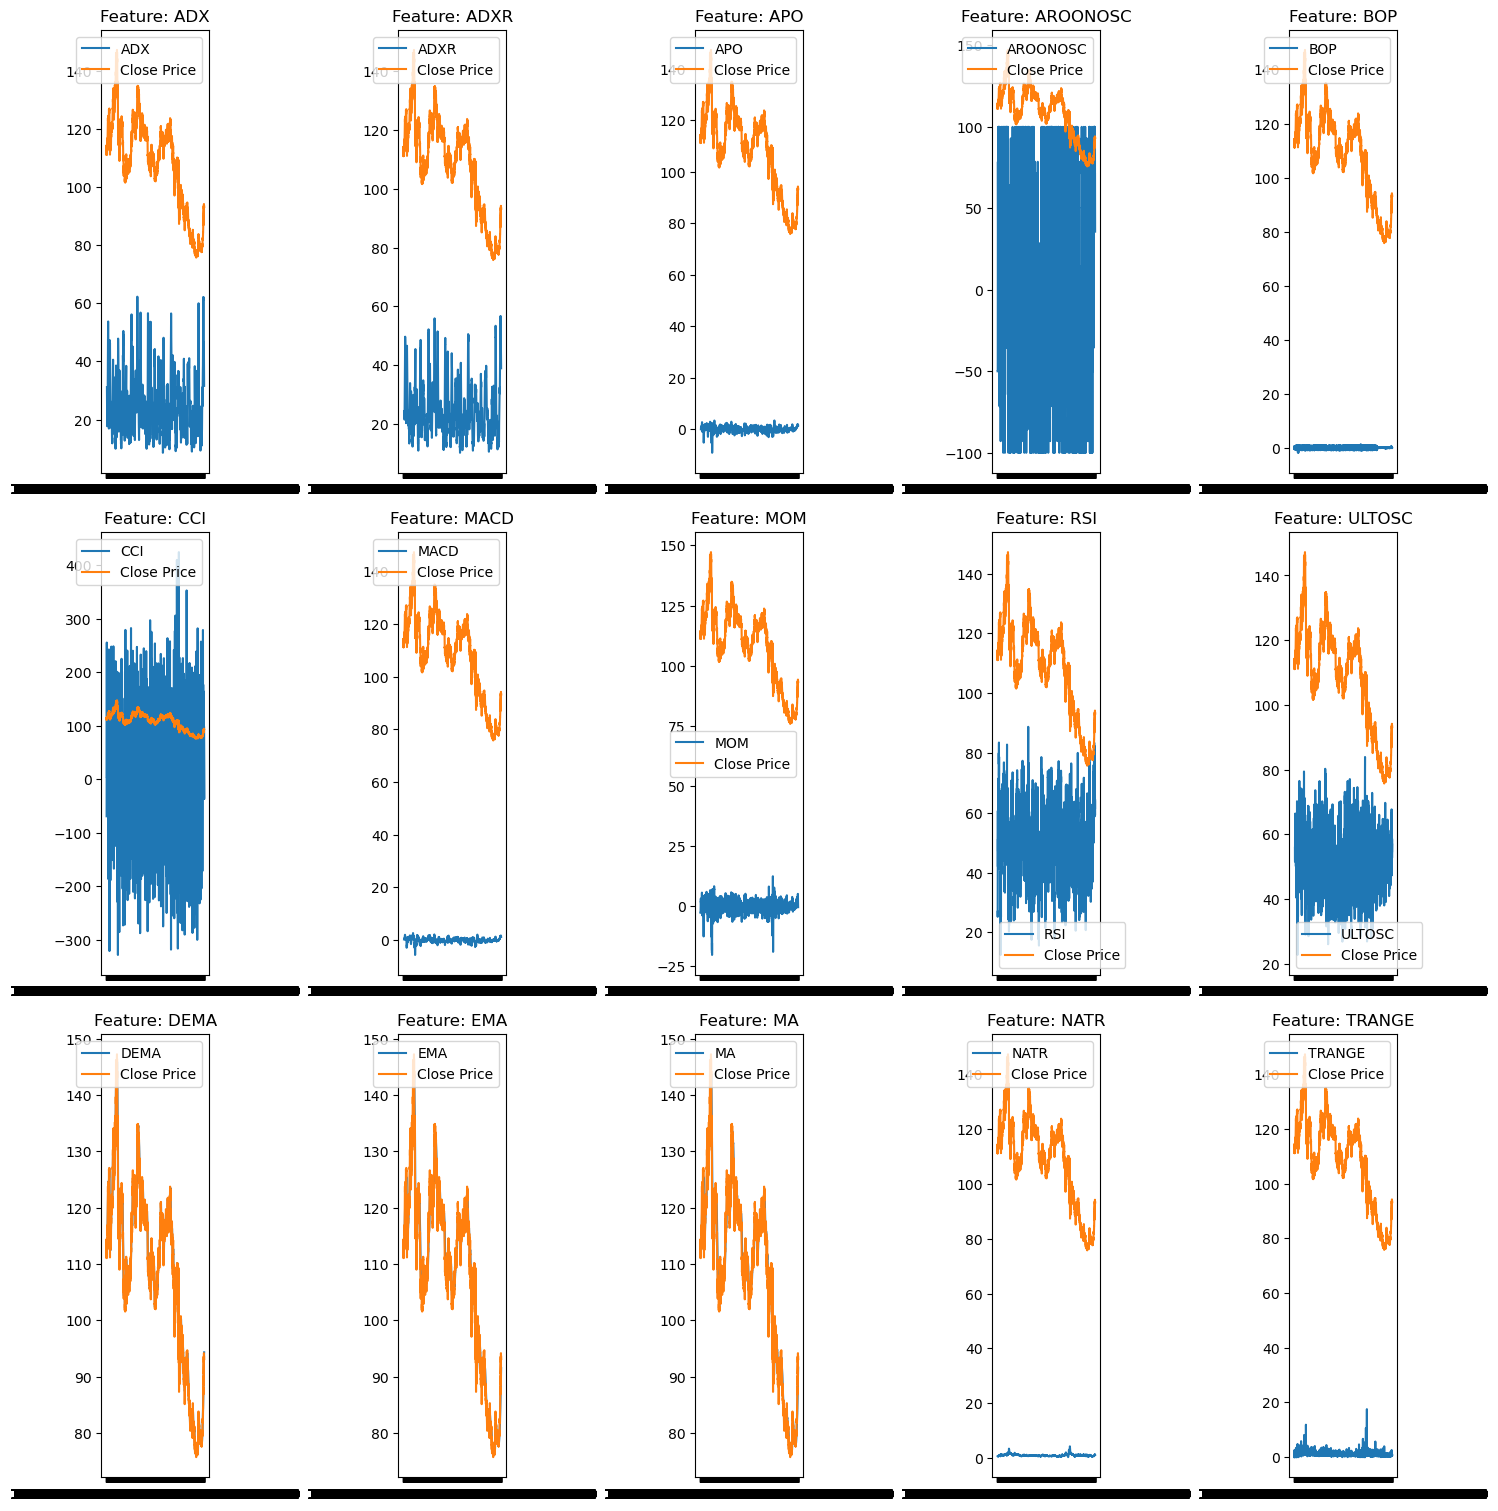

In [14]:

n_rows = 4
n_cols = 5

plt.figure(figsize=(15, 20))

for i, column in enumerate(ta_features.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(ta_features.index, ta_features[column], label=column)
    plt.plot(ta_features.index, train['Close'], label='Close Price')
    plt.title(f"Feature: {column}")
    plt.legend()

plt.tight_layout()
plt.show()

In [25]:
features = pd.concat([features_characteristics, ta_features],axis =1)
y_train = features['forward_return_3']
X_train = features.drop('forward_return_3', axis=1)
X_train.index = pd .to_datetime(X_train.index)

In [26]:
X_train

,forward_return_1,return_1,return_3,forward_return_5,return_5,forward_return_10,return_10,volatility_5,volatility_10,volatility_20,...,CCI,MACD,MOM,RSI,ULTOSC,DEMA,EMA,MA,NATR,TRANGE
Date,,,,,,,,,,,,,,,,,,,,,
1996-10-29 19:00:00-05:00,0.000000,NaN,NaN,-0.002014,NaN,-0.024785,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-10-30 19:00:00-05:00,-0.005956,0.000000,NaN,-0.002014,NaN,-0.024785,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1996-10-31 19:00:00-05:00,0.003348,-0.005956,NaN,-0.015507,NaN,-0.021586,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.680000
1996-11-03 19:00:00-05:00,0.003249,0.003348,-0.002627,-0.024236,NaN,-0.021777,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.030006
1996-11-04 19:00:00-05:00,-0.002626,0.003249,0.000613,-0.025558,NaN,-0.023370,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.880005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-17 19:00:00-05:00,-0.000768,0.008230,0.004469,NaN,0.012828,NaN,0.010262,0.168989,0.158782,0.156108,...,98.338755,1.484784,0.952003,64.476351,56.615309,93.911771,90.916215,90.860533,1.328731,1.224998
2013-02-18 19:00:00-05:00,0.000619,-0.000768,0.004225,NaN,-0.005744,NaN,0.016245,0.100684,0.153432,0.153326,...,70.691302,1.440997,1.497002,63.941581,52.788137,94.059877,91.092588,91.073767,1.276415,0.545997
2013-02-19 19:00:00-05:00,-0.000512,0.000619,0.008079,NaN,0.004319,NaN,0.001475,0.068955,0.133002,0.144088,...,51.605218,1.394897,0.138000,64.199175,58.649570,94.195025,91.261324,91.301767,1.231158,0.612000


In [30]:
# Be careful in this step, in case that bringring in no consistence in the time series
X_train = X_train.dropna()
X_train



,forward_return_1,return_1,return_3,forward_return_5,return_5,forward_return_10,return_10,volatility_5,volatility_10,volatility_20,...,CCI,MACD,MOM,RSI,ULTOSC,DEMA,EMA,MA,NATR,TRANGE
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-19 19:00:00-05:00,-0.000254,0.005029,0.009763,0.013739,0.012277,0.031719,0.019013,0.062334,0.060931,0.062880,...,187.897435,0.881815,2.200005,70.137756,60.483974,117.097036,115.473305,115.237333,0.781276,0.989998
1997-01-20 19:00:00-05:00,0.000424,-0.000254,0.011498,0.026468,0.008038,0.038853,0.023086,0.063102,0.052404,0.063008,...,150.059279,0.921713,2.659996,69.757766,59.642249,117.292802,115.628576,115.388333,0.775342,0.820000
1997-01-21 19:00:00-05:00,0.010769,0.000424,0.005199,0.026032,0.009934,0.047147,0.017954,0.058608,0.049897,0.063091,...,129.178332,0.946458,2.080002,70.048965,57.892512,117.472812,115.777055,115.556667,0.722684,0.050003
1997-01-22 19:00:00-05:00,-0.002936,0.010769,0.010940,0.021393,0.022825,0.038591,0.024847,0.072574,0.066980,0.071285,...,190.643989,1.056369,2.889999,76.292763,57.197512,117.790831,115.997890,115.759000,0.775971,1.870003
1997-01-23 19:00:00-05:00,0.005722,-0.002936,0.008229,0.020194,0.013041,0.036180,0.023598,0.085548,0.069345,0.073051,...,144.244489,1.102523,2.739997,71.847500,55.902811,118.031300,116.181897,115.925667,0.830846,1.800004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-03 19:00:00-05:00,-0.006651,0.011591,0.021809,-0.002533,0.017449,0.010262,0.028709,0.115658,0.160546,0.147874,...,160.687424,1.531339,2.588997,73.469638,58.418585,91.460161,88.651114,88.585566,1.232418,1.462997
2013-02-04 19:00:00-05:00,0.015377,-0.006651,0.012437,0.022115,0.018715,0.016245,0.028493,0.108093,0.160888,0.143675,...,128.189383,1.543436,2.553002,68.295756,47.356042,91.716213,88.877043,88.829333,1.259247,1.382996
2013-02-05 19:00:00-05:00,-0.001443,0.015377,0.020315,-0.002832,0.030620,0.001475,0.056942,0.135979,0.148448,0.147663,...,161.676459,1.648362,5.041001,72.998654,50.093479,92.119050,89.179814,89.115000,1.294496,1.872002


In [36]:
from statsmodels.tsa.stattools import adfuller

non_stationary_columns = []

for column in X_train.columns:
    series = X_train[column].values
    result = adfuller(series)
    print('==========================')
    print(f'Column:{column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))
    
    if result[0] > result[4]['1%'] or result[0] >result[4]['5%'] or result[0] > result[4]['10%']:
        non_stationary_columns.append(column)
        X_train[column] = X_train[column].diff(periods=5)

non_stationary_columns





Column:forward_return_1
ADF Statistic: -11.917866
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_1
ADF Statistic: -11.843375
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_3
ADF Statistic: -11.250627
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:forward_return_5
ADF Statistic: -10.741139
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_5
ADF Statistic: -10.667471
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:forward_return_10
ADF Statistic: -8.648719
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:return_10
ADF Statistic: -8.533184
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:volatility_5
ADF Statistic: -7.666837
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:volatility_10
ADF Statistic: -6.627296
p-value: 0.0000

['DEMA', 'EMA', 'MA']

In [39]:
X_train = X_train.dropna()

In [40]:
for i in non_stationary_columns:
    result = adfuller(X_train[i].values)
    print('==========================')
    print(f'Column:{column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' %(key, value))

Column:TRANGE
ADF Statistic: -9.025246
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:TRANGE
ADF Statistic: -7.541858
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Column:TRANGE
ADF Statistic: -6.896149
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


All features are stationary now.